In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
stock = yf.Ticker("AAPL") 
data = stock.history(start="2015-01-01", end="2025-01-01", auto_adjust=False) 

In [3]:
ts_data = data['Close']

In [4]:
ts_data.head()

Date
2015-01-02 00:00:00-05:00    27.332500
2015-01-05 00:00:00-05:00    26.562500
2015-01-06 00:00:00-05:00    26.565001
2015-01-07 00:00:00-05:00    26.937500
2015-01-08 00:00:00-05:00    27.972500
Name: Close, dtype: float64

In [5]:
train_size = int(len(ts_data) * 0.8)
train_data = ts_data[:train_size]
test_data = ts_data[train_size:]

In [6]:
train_data.shape, test_data.shape

((2012,), (504,))

In [7]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dftest[1] <= 0.05:
        print("-> Series is Stationary (rejecting H0)")
    else:
        print("-> Series is Non-Stationary (failing to reject H0)")

check_stationarity(train_data)

Results of Dickey-Fuller Test:
Test Statistic                   -0.722118
p-value                           0.840937
#Lags Used                       20.000000
Number of Observations Used    1991.000000
Critical Value (1%)              -3.433639
Critical Value (5%)              -2.862993
Critical Value (10%)             -2.567543
dtype: float64
-> Series is Non-Stationary (failing to reject H0)


In [8]:
train_data_diff1 = train_data.diff().dropna()
check_stationarity(train_data_diff1)

Results of Dickey-Fuller Test:
Test Statistic                -9.119995e+00
p-value                        3.224528e-15
#Lags Used                     1.900000e+01
Number of Observations Used    1.991000e+03
Critical Value (1%)           -3.433639e+00
Critical Value (5%)           -2.862993e+00
Critical Value (10%)          -2.567543e+00
dtype: float64
-> Series is Stationary (rejecting H0)


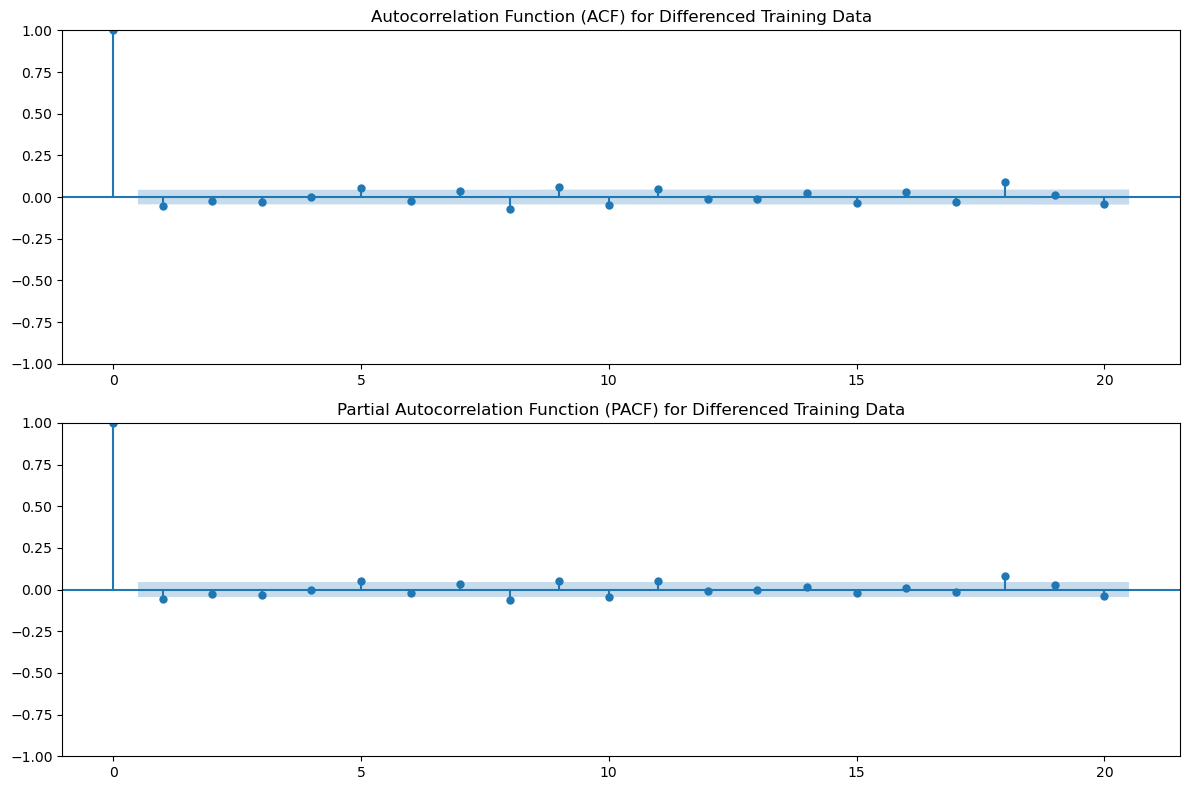

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1) # 2 տող, 1 սյուն, 1-ին գրաֆիկ
plot_acf(train_data_diff1, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) for Differenced Training Data')

plt.subplot(2, 1, 2) # 2 տող, 1 սյուն, 2-րդ գրաֆիկ
plot_pacf(train_data_diff1, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) for Differenced Training Data')

plt.tight_layout() # Գրաֆիկները կոկիկ դասավորելու համար
plt.show()

In [10]:
from pmdarima import auto_arima

print("\nՈրոնում ենք լավագույն ARIMA պարամետրերը auto_arima-ի միջոցով...")

# Օգտագործել auto_arima մարզման տվյալների վրա
# start_p, start_q - p և q-ի սկզբնական արժեքները որոնման համար
# max_p, max_q - p և q-ի առավելագույն արժեքները
# d - դիֆերենցման կարգը (None դեպքում auto_arima-ն ինքն է որոշում)
# seasonal - սեզոնային բաղադրիչի առկայությունը (False բաժնետոմսերի համար)
# stepwise - արագ որոնման համար
# suppress_warnings - զգուշացումները թաքցնելու համար
# error_action - սխալի դեպքում անցնել հաջորդին
# trace - ցույց տալ որոնման ընթացքը

stepwise_fit = auto_arima(train_data, start_p=1, start_q=1,
                          max_p=5, max_q=5,
                          d=None, # Թող auto_arima-ն ինքը որոշի d-ն
                          seasonal=False,
                          stepwise=True,
                          suppress_warnings=True,
                          error_action='ignore',
                          trace=True)

print("\nauto_arima-ի կողմից առաջարկվող լավագույն ARIMA մոդելը:")
print(stepwise_fit.summary())


Որոնում ենք լավագույն ARIMA պարամետրերը auto_arima-ի միջոցով...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8021.743, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8026.138, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8022.196, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8021.833, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8025.670, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8023.582, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8023.605, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8022.182, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8022.570, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8022.162, Time=1.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8021.657, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=8021.572, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=8022.036, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]           

In [11]:
from statsmodels.tsa.arima.model import ARIMA
# ARIMA մոդելի պարամետրերը auto_arima-ից
p, d, q = 0, 1, 1

print(f"\nՀամապատասխանեցնում ենք ARIMA({p}, {d}, {q}) մոդելը մարզման տվյալներին...")
model = ARIMA(train_data, order=(p,d,q))
results = model.fit()

results.summary()


Համապատասխանեցնում ենք ARIMA(0, 1, 1) մոդելը մարզման տվյալներին...


/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2012
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -4008.786
Date:                Wed, 23 Apr 2025   AIC                           8021.572
Time:                        02:09:22   BIC                           8032.785
Sample:                             0   HQIC                          8025.688
                               - 2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0568      0.013     -4.498      0.000      -0.082      -0.032
sigma2         3.1550      0.047     66.622      0.000       3.062       3.248
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4274.22
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              42.57   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
# Կանխատեսում կատարելը թեստային հատվածի համար՝ օգտագործելով թվային ինդեքսներ
# start ինդեքսը test_data-ի սկզբի դիրքն է ամբողջ ts_data-ի մեջ
start_index_num = len(train_data)
# end ինդեքսը test_data-ի վերջի դիրքն է ամբողջ ts_data-ի մեջ
end_index_num = len(ts_data) - 1

print(f"\nԿատարում ենք կանխատեսումներ թվային ինդեքսներով՝ {start_index_num} -ից մինչև {end_index_num}...")

# Օգտագործել թվային ինդեքսները predict ֆունկցիայում
predictions = results.predict(start=start_index_num, end=end_index_num)

# predictions օբյեկտի ինդեքսները կարող են չհամապատասխանել test_data-ի ամսաթվերին։
# Որպեսզի պատկերենք և գնահատենք ճիշտ, պետք է predictions-ի ինդեքսները դարձնենք test_data-ի ինդեքսները։
predictions.index = test_data.index

print("\nԿանխատեսումներն ավարտված են։")
print("Կանխատեսված առաջին 5 արժեքները:")
print(predictions.head(10))


Կատարում ենք կանխատեսումներ թվային ինդեքսներով՝ 2012 -ից մինչև 2515...

Կանխատեսումներն ավարտված են։
Կանխատեսված առաջին 5 արժեքները:
Date
2022-12-29 00:00:00-05:00    126.272575
2022-12-30 00:00:00-05:00    126.272575
2023-01-03 00:00:00-05:00    126.272575
2023-01-04 00:00:00-05:00    126.272575
2023-01-05 00:00:00-05:00    126.272575
2023-01-06 00:00:00-05:00    126.272575
2023-01-09 00:00:00-05:00    126.272575
2023-01-10 00:00:00-05:00    126.272575
2023-01-11 00:00:00-05:00    126.272575
2023-01-12 00:00:00-05:00    126.272575
Name: predicted_mean, dtype: float64


/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [14]:
predictions.head(10)

Date
2022-12-29 00:00:00-05:00    126.272575
2022-12-30 00:00:00-05:00    126.272575
2023-01-03 00:00:00-05:00    126.272575
2023-01-04 00:00:00-05:00    126.272575
2023-01-05 00:00:00-05:00    126.272575
2023-01-06 00:00:00-05:00    126.272575
2023-01-09 00:00:00-05:00    126.272575
2023-01-10 00:00:00-05:00    126.272575
2023-01-11 00:00:00-05:00    126.272575
2023-01-12 00:00:00-05:00    126.272575
Name: predicted_mean, dtype: float64

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [16]:
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f"\nRMSE (Root Mean Squared Error) on test data: {rmse}")
mae = mean_absolute_error(test_data, predictions) 
print(f"MAE (Mean Absolute Error) on test data: {mae}") # Ավելացված MAE ելքը


RMSE (Root Mean Squared Error) on test data: 69.35216782696568
MAE (Mean Absolute Error) on test data: 63.444866241196955


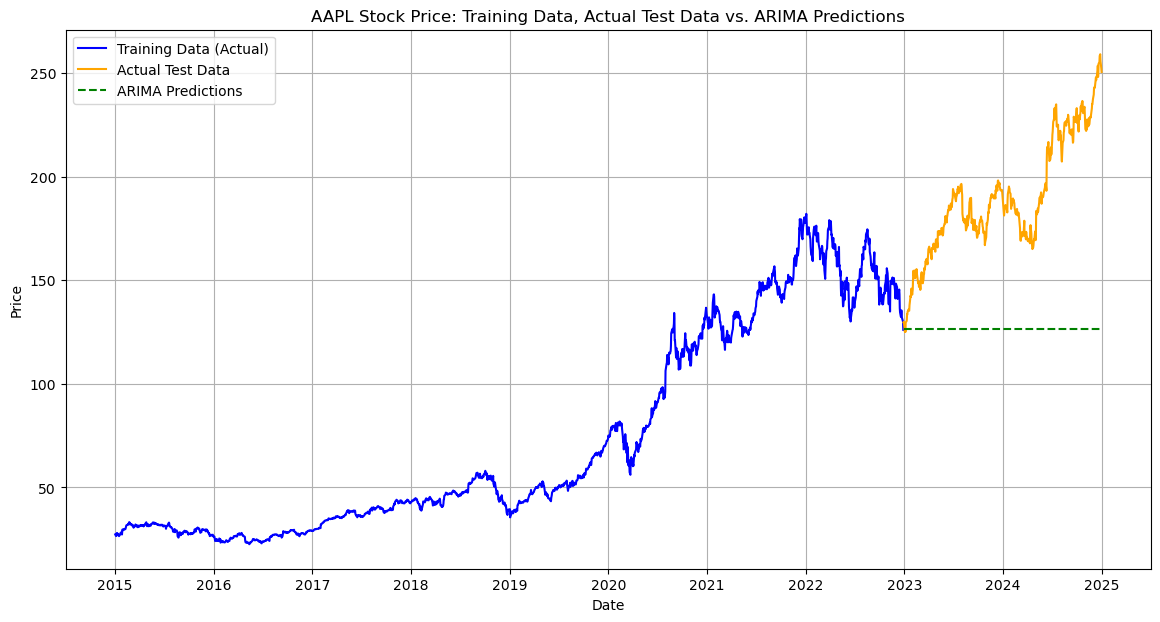

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Training Data (Actual)', color='blue')
plt.plot(test_data, label='Actual Test Data', color='orange')
plt.plot(predictions.index, predictions, label='ARIMA Predictions', color='green', linestyle='--')

plt.title('AAPL Stock Price: Training Data, Actual Test Data vs. ARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# ARIMA մոդելի նոր պարամետրերը
p, d, q = 1, 1, 1

print(f"\nՀամապատասխանեցնում ենք ARIMA({p}, {d}, {q}) մոդելը մարզման տվյալներին...")
model_111 = ARIMA(train_data, order=(p,d,q))
results_111 = model_111.fit()

print("\nARIMA(1,1,1) մոդելը հաջողությամբ համապատասխանեցվել է։")
results_111.summary()


Համապատասխանեցնում ենք ARIMA(1, 1, 1) մոդելը մարզման տվյալներին...

ARIMA(1,1,1) մոդելը հաջողությամբ համապատասխանեցվել է։


/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2012
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4007.829
Date:                Wed, 23 Apr 2025   AIC                           8021.657
Time:                        02:27:28   BIC                           8038.476
Sample:                             0   HQIC                          8027.831
                               - 2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3997      0.167      2.392      0.017       0.072       0.727
ma.L1         -0.4577      0.164     -2.799      0.005      -0.778      -0.137
sigma2         3.1520      0.047     66.546      0.000       3.059       3.245
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4264.11
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              42.59   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
# Օգտագործել results_111 օբյեկտը կանխատեսման համար
predictions_111 = results_111.predict(start=start_index_num, end=end_index_num)

# predictions_111 օբյեկտի ինդեքսները դարձնել test_data-ի ինդեքսները
predictions_111.index = test_data.index
predictions_111.head()

/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Date
2022-12-29 00:00:00-05:00    126.337012
2022-12-30 00:00:00-05:00    126.455717
2023-01-03 00:00:00-05:00    126.503159
2023-01-04 00:00:00-05:00    126.522120
2023-01-05 00:00:00-05:00    126.529699
Name: predicted_mean, dtype: float64

In [20]:
rmse_111 = np.sqrt(mean_squared_error(test_data, predictions_111))
mae_111 = mean_absolute_error(test_data, predictions_111)

In [21]:
print(f"\nRMSE (Root Mean Squared Error) on test data (ARIMA 1,1,1): {rmse_111}")
print(f"MAE (Mean Absolute Error) on test data (ARIMA 1,1,1): {mae_111}")


RMSE (Root Mean Squared Error) on test data (ARIMA 1,1,1): 69.11247280700627
MAE (Mean Absolute Error) on test data (ARIMA 1,1,1): 63.18592969865393


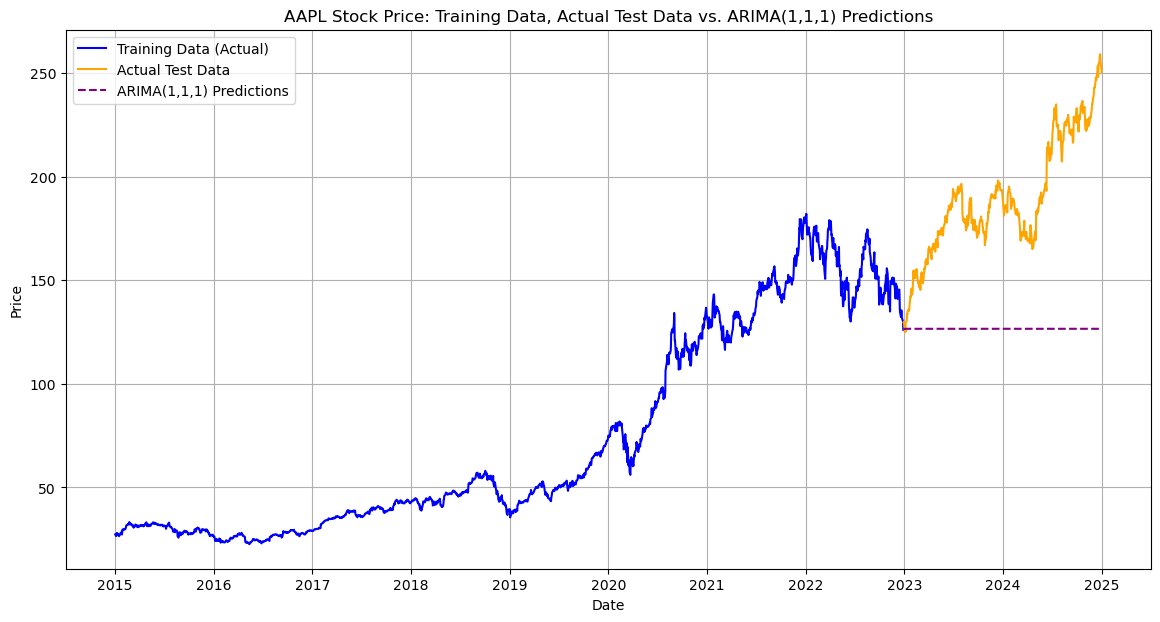

In [22]:
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Training Data (Actual)', color='blue')
plt.plot(test_data, label='Actual Test Data', color='orange')
plt.plot(predictions_111.index, predictions_111, label='ARIMA(1,1,1) Predictions', color='purple', linestyle='--') # Փոխել գույնը՝ տարբերելու համար

plt.title('AAPL Stock Price: Training Data, Actual Test Data vs. ARIMA(1,1,1) Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
p, d, q = 10, 1, 10

print(f"\nՀամապատասխանեցնում ենք ARIMA({p}, {d}, {q}) մոդելը մարզման տվյալներին...")
model_10 = ARIMA(train_data, order=(p,d,q))
results_10 = model_10.fit()

print("\nARIMA(10,1,10) մոդելը հաջողությամբ համապատասխանեցվել է։")
results_10.summary()


Համապատասխանեցնում ենք ARIMA(10, 1, 10) մոդելը մարզման տվյալներին...


/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim


ARIMA(10,1,10) մոդելը հաջողությամբ համապատասխանեցվել է։


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2012
Model:               ARIMA(10, 1, 10)   Log Likelihood               -3979.502
Date:                Wed, 23 Apr 2025   AIC                           8001.005
Time:                        02:27:58   BIC                           8118.739
Sample:                             0   HQIC                          8044.222
                               - 2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7828      0.307     -2.549      0.011      -1.385      -0.181
ar.L2         -0.1093      0.176     -0.621      0.534      -0.454       0.236
ar.L3          0.2222      0.141      1.576      0.115      -0.054       0.498
ar.L4         -0.1432      0.052     -2.734      0.006      -0.246      -0.041
ar.L5         -0.2801      0.091     -3.061      0.002      -0.459      -0.101
ar.L6          0.1014      0.056      1.818      0.069      -0.008       0.211
ar.L7          0.3300      0.080      4.100      0.000       0.172       0.488
ar.L8         -0.5864      0.096     -6.130      0.000      -0.774      -0.399
ar.L9         -0.8084      0.251     -3.227      0.001      -1.299      -0.317
ar.L10        -0.5715      0.201     -2.850      0.004      -0.965      -0.178
ma.L1          0.7562      0.310      2.436      0.015       0.148       1.365
ma.L2          0.0824      0.173      0.476      0.634      -0.257       0.422
ma.L3         -0.2406      0.146     -1.652      0.098      -0.526       0.045
ma.L4          0.1116      0.050      2.228      0.026       0.013       0.210
ma.L5          0.2807      0.081      3.479      0.001       0.123       0.439
ma.L6         -0.1220      0.058     -2.091      0.037      -0.236      -0.008
ma.L7         -0.3375      0.084     -4.013      0.000      -0.502      -0.173
ma.L8          0.5475      0.103      5.323      0.000       0.346       0.749
ma.L9          0.8173      0.245      3.338      0.001       0.337       1.297
ma.L10         0.5382      0.206      2.611      0.009       0.134       0.942
sigma2         3.1025      0.051     60.945      0.000       3.003       3.202
===================================================================================
Ljung-Box (L1) (Q):                   1.11   Jarque-Bera (JB):              3794.93
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):              40.84   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
predictions_10 = results_10.predict(start=start_index_num, end=end_index_num)

# predictions_111 օբյեկտի ինդեքսները դարձնել test_data-ի ինդեքսները
predictions_10.index = test_data.index
predictions_10.head()

/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Date
2022-12-29 00:00:00-05:00    126.608912
2022-12-30 00:00:00-05:00    127.370271
2023-01-03 00:00:00-05:00    126.887155
2023-01-04 00:00:00-05:00    126.855263
2023-01-05 00:00:00-05:00    126.760605
Name: predicted_mean, dtype: float64

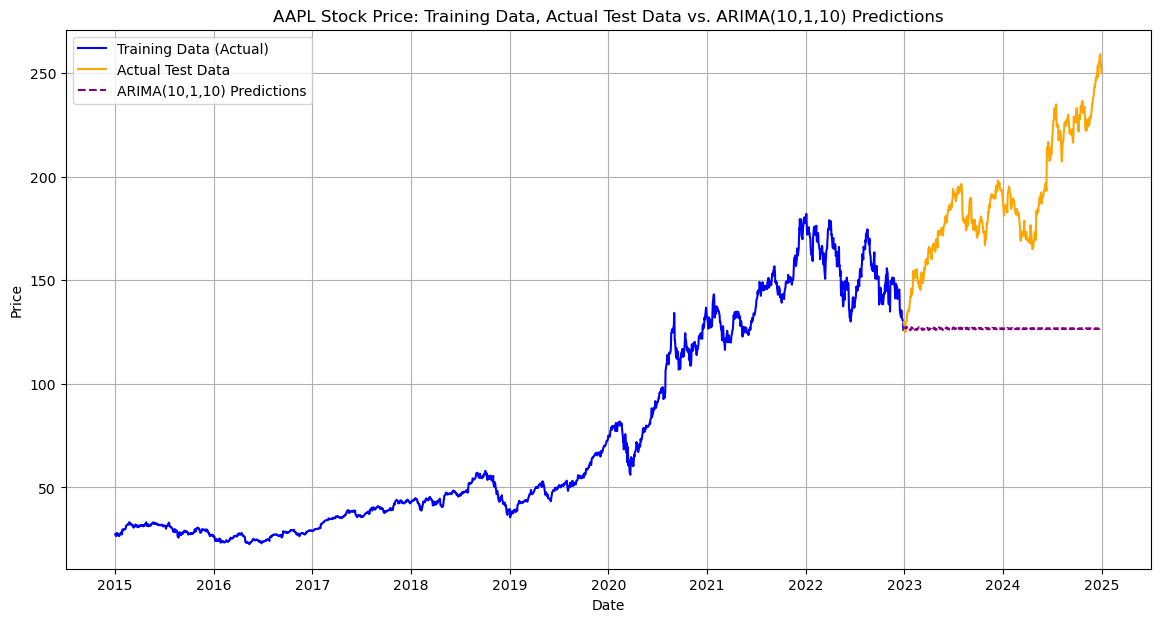

In [25]:
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Training Data (Actual)', color='blue')
plt.plot(test_data, label='Actual Test Data', color='orange')
plt.plot(predictions_10.index, predictions_10, label='ARIMA(10,1,10) Predictions', color='purple', linestyle='--') # Փոխել գույնը՝ տարբերելու համար

plt.title('AAPL Stock Price: Training Data, Actual Test Data vs. ARIMA(10,1,10) Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
p, d, q = 50, 1, 50

print(f"\nՀամապատասխանեցնում ենք ARIMA({p}, {d}, {q}) մոդելը մարզման տվյալներին...")
model_50 = ARIMA(train_data, order=(p,d,q))
results_50 = model_50.fit()

print("\nARIMA(50,1,50) մոդելը հաջողությամբ համապատասխանեցվել է։")
results_50.summary()


Համապատասխանեցնում ենք ARIMA(50, 1, 50) մոդելը մարզման տվյալներին...


/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible st


ARIMA(50,1,50) մոդելը հաջողությամբ համապատասխանեցվել է։


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2012
Model:               ARIMA(50, 1, 50)   Log Likelihood               -3890.455
Date:                Wed, 23 Apr 2025   AIC                           7982.911
Time:                        02:39:45   BIC                           8549.156
Sample:                             0   HQIC                          8190.767
                               - 2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0910      1.086     -0.084      0.933      -2.219       2.037
ar.L2          0.1158      1.120      0.103      0.918      -2.079       2.311
ar.L3         -0.0179      0.939     -0.019      0.985      -1.858       1.822
ar.L4         -0.0544      0.832     -0.065      0.948      -1.686       1.577
ar.L5          0.1848      0.667      0.277      0.782      -1.122       1.492
ar.L6          0.1326      0.620      0.214      0.831      -1.083       1.348
ar.L7          0.1408      0.510      0.276      0.783      -0.859       1.140
ar.L8          0.0714      0.350      0.204      0.839      -0.615       0.758
ar.L9          0.0881      0.371      0.238      0.812      -0.639       0.815
ar.L10         0.0367      0.394      0.093      0.926      -0.736       0.809
ar.L11         0.0533      0.310      0.172      0.863      -0.555       0.661
ar.L12         0.0345      0.328      0.105      0.916      -0.609       0.678
ar.L13        -0.1139      0.305     -0.374      0.709      -0.711       0.483
ar.L14        -0.1074      0.354     -0.304      0.761      -0.800       0.586
ar.L15         0.0218      0.380      0.057      0.954      -0.723       0.766
ar.L16        -0.1088      0.284     -0.383      0.702      -0.666       0.449
ar.L17        -0.0740      0.298     -0.248      0.804      -0.658       0.510
ar.L18         0.2904      0.278      1.046      0.296      -0.254       0.835
ar.L19         0.1898      0.486      0.390      0.696      -0.763       1.143
ar.L20        -0.0007      0.506     -0.001      0.999      -0.993       0.991
ar.L21         0.0743      0.389      0.191      0.849      -0.689       0.838
ar.L22         0.0939      0.406      0.231      0.817      -0.702       0.889
ar.L23        -0.0676      0.371     -0.182      0.855      -0.795       0.660
ar.L24        -0.1354      0.378     -0.359      0.720      -0.876       0.605
ar.L25         0.0869      0.381      0.228      0.820      -0.660       0.834
ar.L26         0.0744      0.361      0.206      0.837      -0.633       0.782
ar.L27        -0.1584      0.380     -0.417      0.677      -0.903       0.586
ar.L28         0.0269      0.339      0.080      0.937      -0.637       0.691
ar.L29         0.0883      0.380      0.232      0.816      -0.656       0.833
ar.L30        -0.1651      0.312     -0.530      0.596      -0.776       0.446
ar.L31        -0.2533      0.440     -0.575      0.565      -1.116       0.610
ar.L32        -0.0197      0.503     -0.039      0.969      -1.005       0.965
ar.L33         0.1116      0.402      0.278      0.781      -0.676       0.899
ar.L34         0.0238      0.442      0.054      0.957      -0.843       0.890
ar.L35         0.0135      0.293      0.046      0.963      -0.561       0.588
ar.L36         0.2726      0.294      0.927      0.354      -0.304       0.849
ar.L37        -0.1365      0.362     -0.377      0.706      -0.846       0.573
ar.L38        -0.0228      0.441     -0.052      0.959      -0.887       0.842
ar

In [27]:
predictions_50 = results_50.predict(start=start_index_num, end=end_index_num)

predictions_50.index = test_data.index
predictions_50.head()

/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Date
2022-12-29 00:00:00-05:00    127.271948
2022-12-30 00:00:00-05:00    128.600670
2023-01-03 00:00:00-05:00    128.000337
2023-01-04 00:00:00-05:00    127.807315
2023-01-05 00:00:00-05:00    127.252153
Name: predicted_mean, dtype: float64

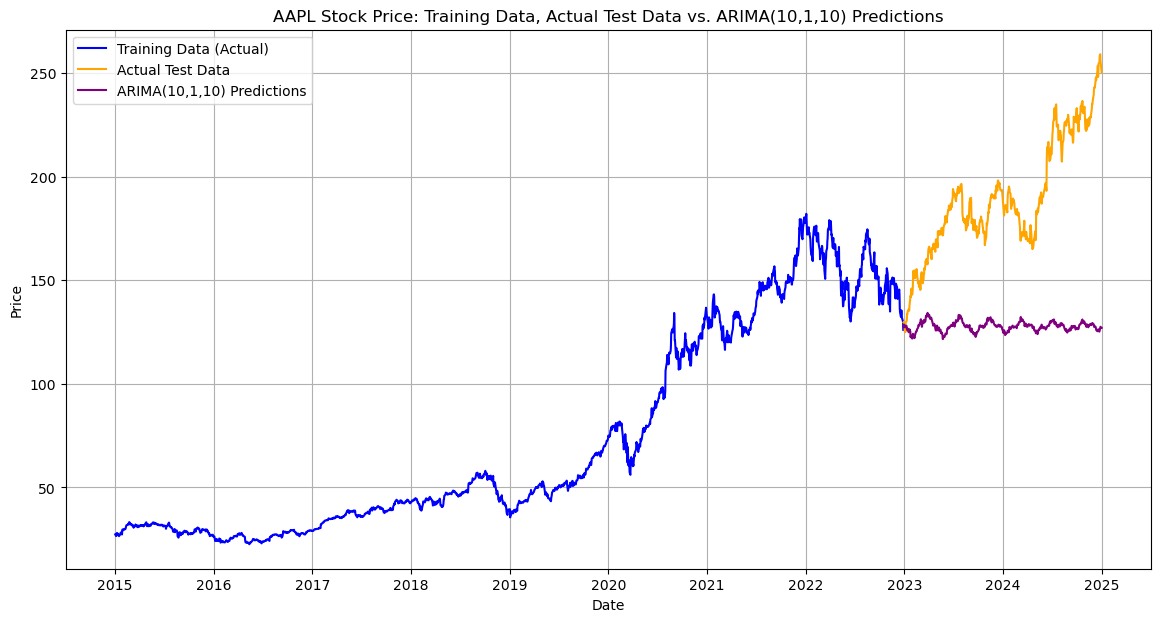

In [28]:
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Training Data (Actual)', color='blue')
plt.plot(test_data, label='Actual Test Data', color='orange')
plt.plot(predictions_50.index, predictions_50, label='ARIMA(10,1,10) Predictions', color='purple') 

plt.title('AAPL Stock Price: Training Data, Actual Test Data vs. ARIMA(10,1,10) Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()